# Credits predicting - MSHP competition 2023 S211

# Import libraries

In [1]:
# Data
import pandas as pd
import numpy as np

## Drawing
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

## Train, test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

## Impute data
from sklearn.impute import SimpleImputer

# Data preprocess

In [2]:
df_train = pd.read_csv('./datasets/credit_train.csv')
df_test = pd.read_csv('./datasets/credit_test.csv')

In [3]:
df_train

,id,gender,age,marital_status,credit_sum,credit_month,tariff_id,education,credit_count,overdue_credit_count,job_pos,credit_score,region,income,opened
0,26031,M,24,UNM,"24000,00",10,1.60,SCH,2.0,0.0,SPC,"0,728851",ОБЛ ЛЕНИНГРАДСКАЯ,35000.0,True
1,148877,M,23,UNM,"16339,00",18,1.10,SCH,2.0,0.0,SPC,"0,347385",МОСКВА Г,38000.0,True
2,142019,M,54,UNM,"15652,00",10,1.32,GRD,2.0,0.0,SPC,"0,349705",ОБЛ МОСКОВСКАЯ,38000.0,True
3,146816,F,52,UNM,"16560,00",10,1.10,SCH,1.0,0.0,SPC,"0,359232",РЕСП МОРДОВИЯ,28000.0,False
4,27699,F,63,WID,"9078,00",18,1.10,SCH,4.0,0.0,SPC,"0,529368",ЧЕЛЯБИНСКАЯ ОБЛ,30000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,119880,M,29,MAR,"29678,00",10,1.60,GRD,1.0,0.0,SPC,"0,721156",ОМСКАЯ ОБЛАСТЬ,25000.0,False
114395,103695,M,29,MAR,"23068,00",15,1.10,GRD,3.0,0.0,SPC,"0,566393",ТЮМЕНСКАЯ ОБЛ,30000.0,True
114396,131933,F,45,MAR,"16418,00",10,1.10,SCH,1.0,0.0,UMN,"0,327380",ОБЛ БРЯНСКАЯ,30400.0,False
114397,146868,F,49,MAR,"12169,00",10,1.40,SCH,1.0,0.0,SPC,"0,467395",ТАМБОВСКАЯ ОБЛ,16000.0,False


array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'credit_month'}>],
       [<Axes: title={'center': 'tariff_id'}>,
        <Axes: title={'center': 'credit_count'}>,
        <Axes: title={'center': 'overdue_credit_count'}>],
       [<Axes: title={'center': 'income'}>, <Axes: >, <Axes: >]],
      dtype=object)

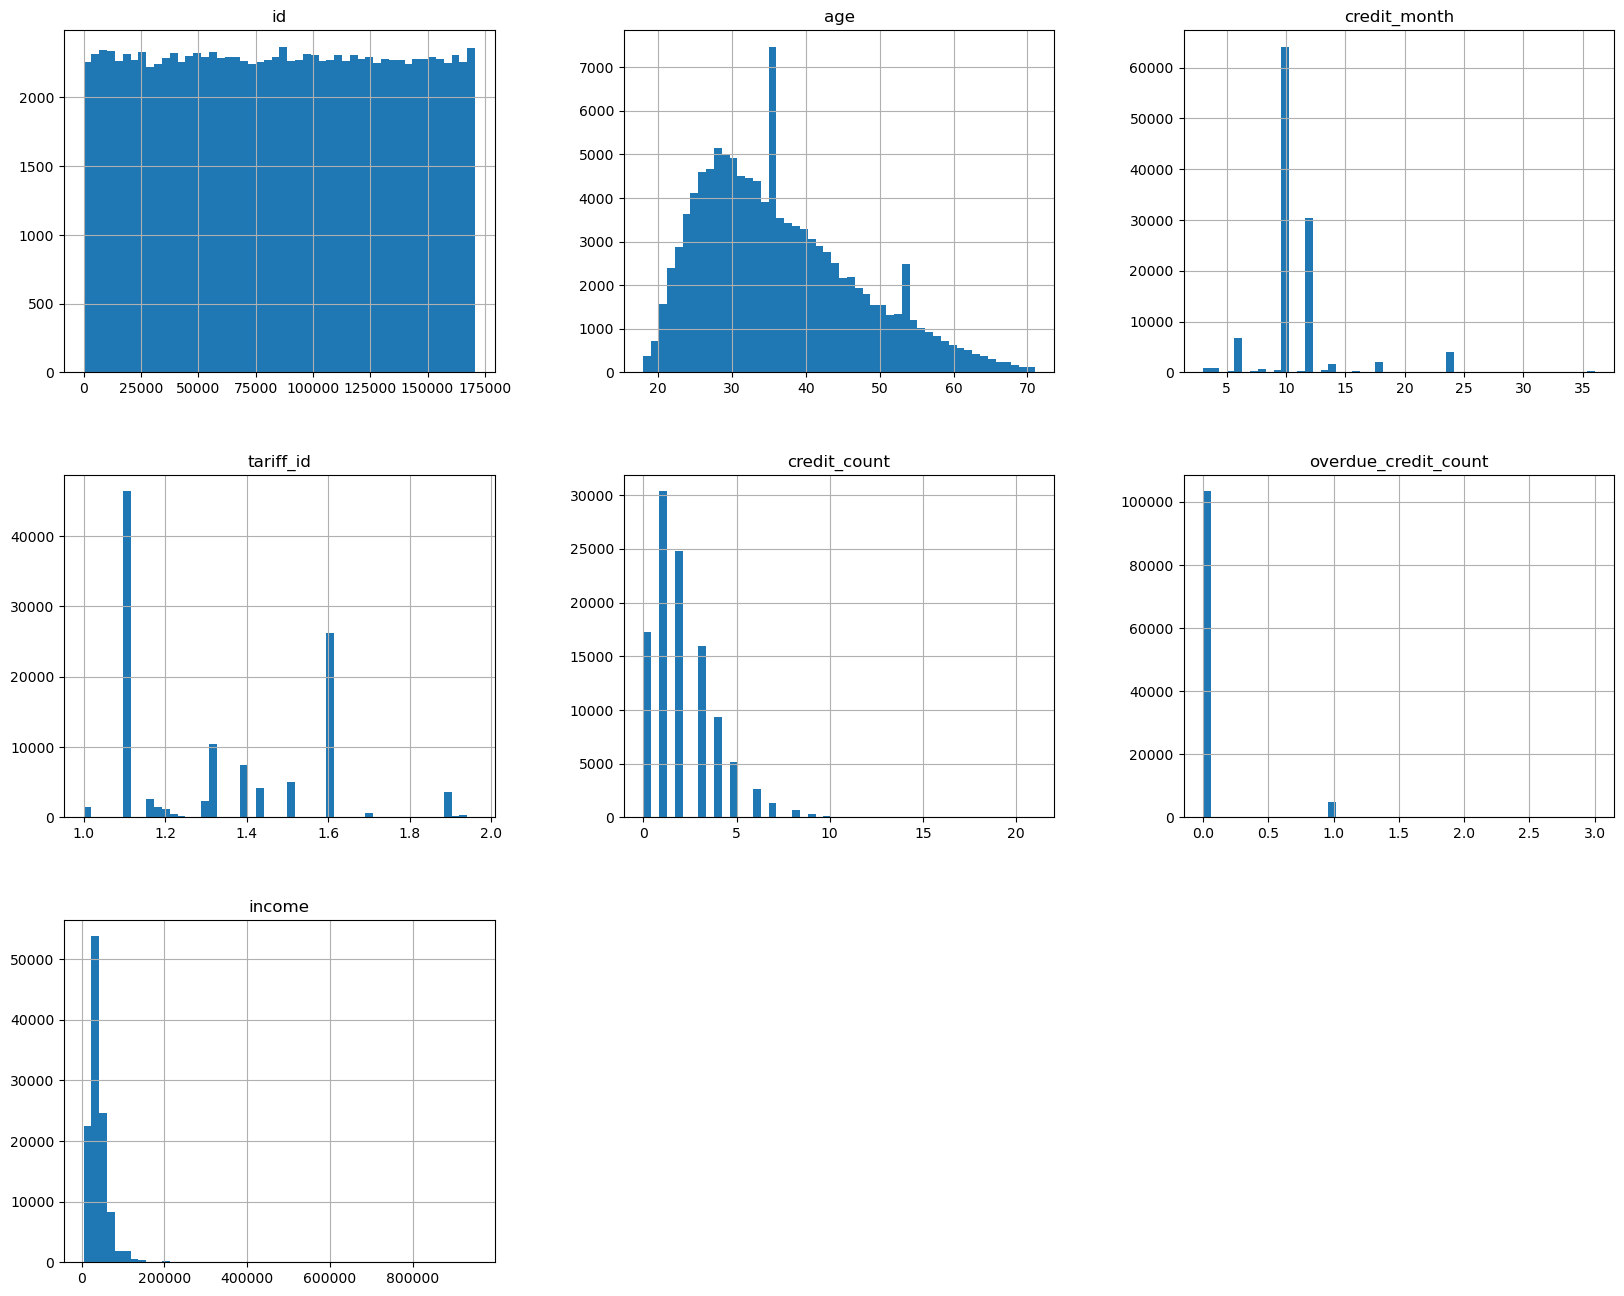

In [4]:
df_train.hist(bins=50, figsize=(20, 16))

Видим что некоторые "числа" записаны через запятую - не круто. Удалим id, tariff_id никакого смысла не несет :/

Стратификацию делать стоит, потому что кроме credit_score все признаки распределены не ровно, поэтому стоит хоть как то выровнять выборку

In [5]:
df_train.drop(columns = ['id'], axis=1, inplace=True)
df_test.drop(columns = ['id'], axis=1, inplace=True)
df_train.drop(columns = ['tariff_id'], axis=1, inplace=True)
df_test.drop(columns = ['tariff_id'], axis=1, inplace=True)

In [6]:
df_train

,gender,age,marital_status,credit_sum,credit_month,education,credit_count,overdue_credit_count,job_pos,credit_score,region,income,opened
0,M,24,UNM,"24000,00",10,SCH,2.0,0.0,SPC,"0,728851",ОБЛ ЛЕНИНГРАДСКАЯ,35000.0,True
1,M,23,UNM,"16339,00",18,SCH,2.0,0.0,SPC,"0,347385",МОСКВА Г,38000.0,True
2,M,54,UNM,"15652,00",10,GRD,2.0,0.0,SPC,"0,349705",ОБЛ МОСКОВСКАЯ,38000.0,True
3,F,52,UNM,"16560,00",10,SCH,1.0,0.0,SPC,"0,359232",РЕСП МОРДОВИЯ,28000.0,False
4,F,63,WID,"9078,00",18,SCH,4.0,0.0,SPC,"0,529368",ЧЕЛЯБИНСКАЯ ОБЛ,30000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,M,29,MAR,"29678,00",10,GRD,1.0,0.0,SPC,"0,721156",ОМСКАЯ ОБЛАСТЬ,25000.0,False
114395,M,29,MAR,"23068,00",15,GRD,3.0,0.0,SPC,"0,566393",ТЮМЕНСКАЯ ОБЛ,30000.0,True
114396,F,45,MAR,"16418,00",10,SCH,1.0,0.0,UMN,"0,327380",ОБЛ БРЯНСКАЯ,30400.0,False
114397,F,49,MAR,"12169,00",10,SCH,1.0,0.0,SPC,"0,467395",ТАМБОВСКАЯ ОБЛ,16000.0,False


In [7]:
df_train['credit_sum'] = df_train['credit_sum'].map(lambda x: x.replace(',', '.'))
df_train['credit_score'] = df_train['credit_score'].map(lambda x: x.replace(',', '.'))

df_train['credit_sum'] = df_train['credit_sum'].astype(dtype=np.float64)
df_train['credit_score'] = df_train['credit_score'].astype(dtype=np.float64)

df_train['opened'] = df_train['opened'].astype(dtype=np.int64)

In [8]:
df_test['credit_sum'] = df_test['credit_sum'].map(lambda x: x.replace(',', '.'))
df_test['credit_score'] = df_test['credit_score'].map(lambda x: x.replace(',', '.'))

df_test['credit_sum'] = df_test['credit_sum'].astype(dtype=np.float64)
df_test['credit_score'] = df_test['credit_score'].astype(dtype=np.float64)

## Выделим категориальные и числовые признаки

In [9]:
categorical_train = df_train.select_dtypes(include=[object])
number_train = df_train.select_dtypes(include=[int, float, bool])

In [10]:
df_train.isna().sum()

gender                     0
age                        0
marital_status             0
credit_sum                 0
credit_month               0
education                  0
credit_count            6189
overdue_credit_count    6189
job_pos                    0
credit_score               0
region                   132
income                     0
opened                     0
dtype: int64

## Impute nans

In [11]:
imp_median = SimpleImputer(strategy='median')

In [12]:
imp_median.fit(number_train)

SimpleImputer(strategy='median')

In [20]:
number_train_imputed = pd.DataFrame(imp_median.transform(number_train), columns=number_train.columns)

In [21]:
number_train_imputed

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,opened
0,24.0,24000.0,10.0,2.0,0.0,0.728851,35000.0,1.0
1,23.0,16339.0,18.0,2.0,0.0,0.347385,38000.0,1.0
2,54.0,15652.0,10.0,2.0,0.0,0.349705,38000.0,1.0
3,52.0,16560.0,10.0,1.0,0.0,0.359232,28000.0,0.0
4,63.0,9078.0,18.0,4.0,0.0,0.529368,30000.0,0.0
...,...,...,...,...,...,...,...,...
114394,29.0,29678.0,10.0,1.0,0.0,0.721156,25000.0,0.0
114395,29.0,23068.0,15.0,3.0,0.0,0.566393,30000.0,1.0
114396,45.0,16418.0,10.0,1.0,0.0,0.327380,30400.0,0.0
114397,49.0,12169.0,10.0,1.0,0.0,0.467395,16000.0,0.0


## One-Hot Encode

In [22]:
categorical_train_encoded = pd.get_dummies(categorical_train).astype(dtype=np.int32)

In [23]:
categorical_train_encoded

,gender_F,gender_M,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID,education_ACD,education_GRD,education_PGR,...,region_ЧИТИНСКАЯ ОБЛ,region_ЧУВАШИЯ ЧУВАШСКАЯ РЕСПУБЛИКА -,region_ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП,region_ЧУВАШСКАЯ РЕСПУБЛИКА,region_ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ,region_ЧУКОТСКИЙ АО,region_ЭВЕНКИЙСКИЙ АО,region_ЯМАЛО-НЕНЕЦКИЙ АО,region_ЯРОСЛАВСКАЯ ОБЛ,region_ЯРОСЛАВСКАЯ ОБЛАСТЬ
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
114395,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
114396,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114397,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Concatenate 2 dataframes

In [24]:
df_train_prepared = pd.concat([number_train_imputed, categorical_train_encoded], axis=1)

In [25]:
df_train_prepared

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,opened,gender_F,gender_M,...,region_ЧИТИНСКАЯ ОБЛ,region_ЧУВАШИЯ ЧУВАШСКАЯ РЕСПУБЛИКА -,region_ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП,region_ЧУВАШСКАЯ РЕСПУБЛИКА,region_ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ,region_ЧУКОТСКИЙ АО,region_ЭВЕНКИЙСКИЙ АО,region_ЯМАЛО-НЕНЕЦКИЙ АО,region_ЯРОСЛАВСКАЯ ОБЛ,region_ЯРОСЛАВСКАЯ ОБЛАСТЬ
0,24.0,24000.0,10.0,2.0,0.0,0.728851,35000.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,23.0,16339.0,18.0,2.0,0.0,0.347385,38000.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,54.0,15652.0,10.0,2.0,0.0,0.349705,38000.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,52.0,16560.0,10.0,1.0,0.0,0.359232,28000.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,63.0,9078.0,18.0,4.0,0.0,0.529368,30000.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,29.0,29678.0,10.0,1.0,0.0,0.721156,25000.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
114395,29.0,23068.0,15.0,3.0,0.0,0.566393,30000.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
114396,45.0,16418.0,10.0,1.0,0.0,0.327380,30400.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
114397,49.0,12169.0,10.0,1.0,0.0,0.467395,16000.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df_train_prepared.isna().sum()

age                           0
credit_sum                    0
credit_month                  0
credit_count                  0
overdue_credit_count          0
                             ..
region_ЧУКОТСКИЙ АО           0
region_ЭВЕНКИЙСКИЙ АО         0
region_ЯМАЛО-НЕНЕЦКИЙ АО      0
region_ЯРОСЛАВСКАЯ ОБЛ        0
region_ЯРОСЛАВСКАЯ ОБЛАСТЬ    0
Length: 322, dtype: int64

## Stratified shuffle

Применим стратификацию, потому что выборка явно не сбалансированная

In [29]:
split = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=42)
for train_index, test_index in split.split(df_train, df_train['opened']):
    strat_train_set = df_train.loc[train_index]
    strat_test_set = df_train.loc[test_index]

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'credit_sum'}>,
        <Axes: title={'center': 'credit_month'}>],
       [<Axes: title={'center': 'credit_count'}>,
        <Axes: title={'center': 'overdue_credit_count'}>,
        <Axes: title={'center': 'credit_score'}>],
       [<Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'opened'}>, <Axes: >]], dtype=object)

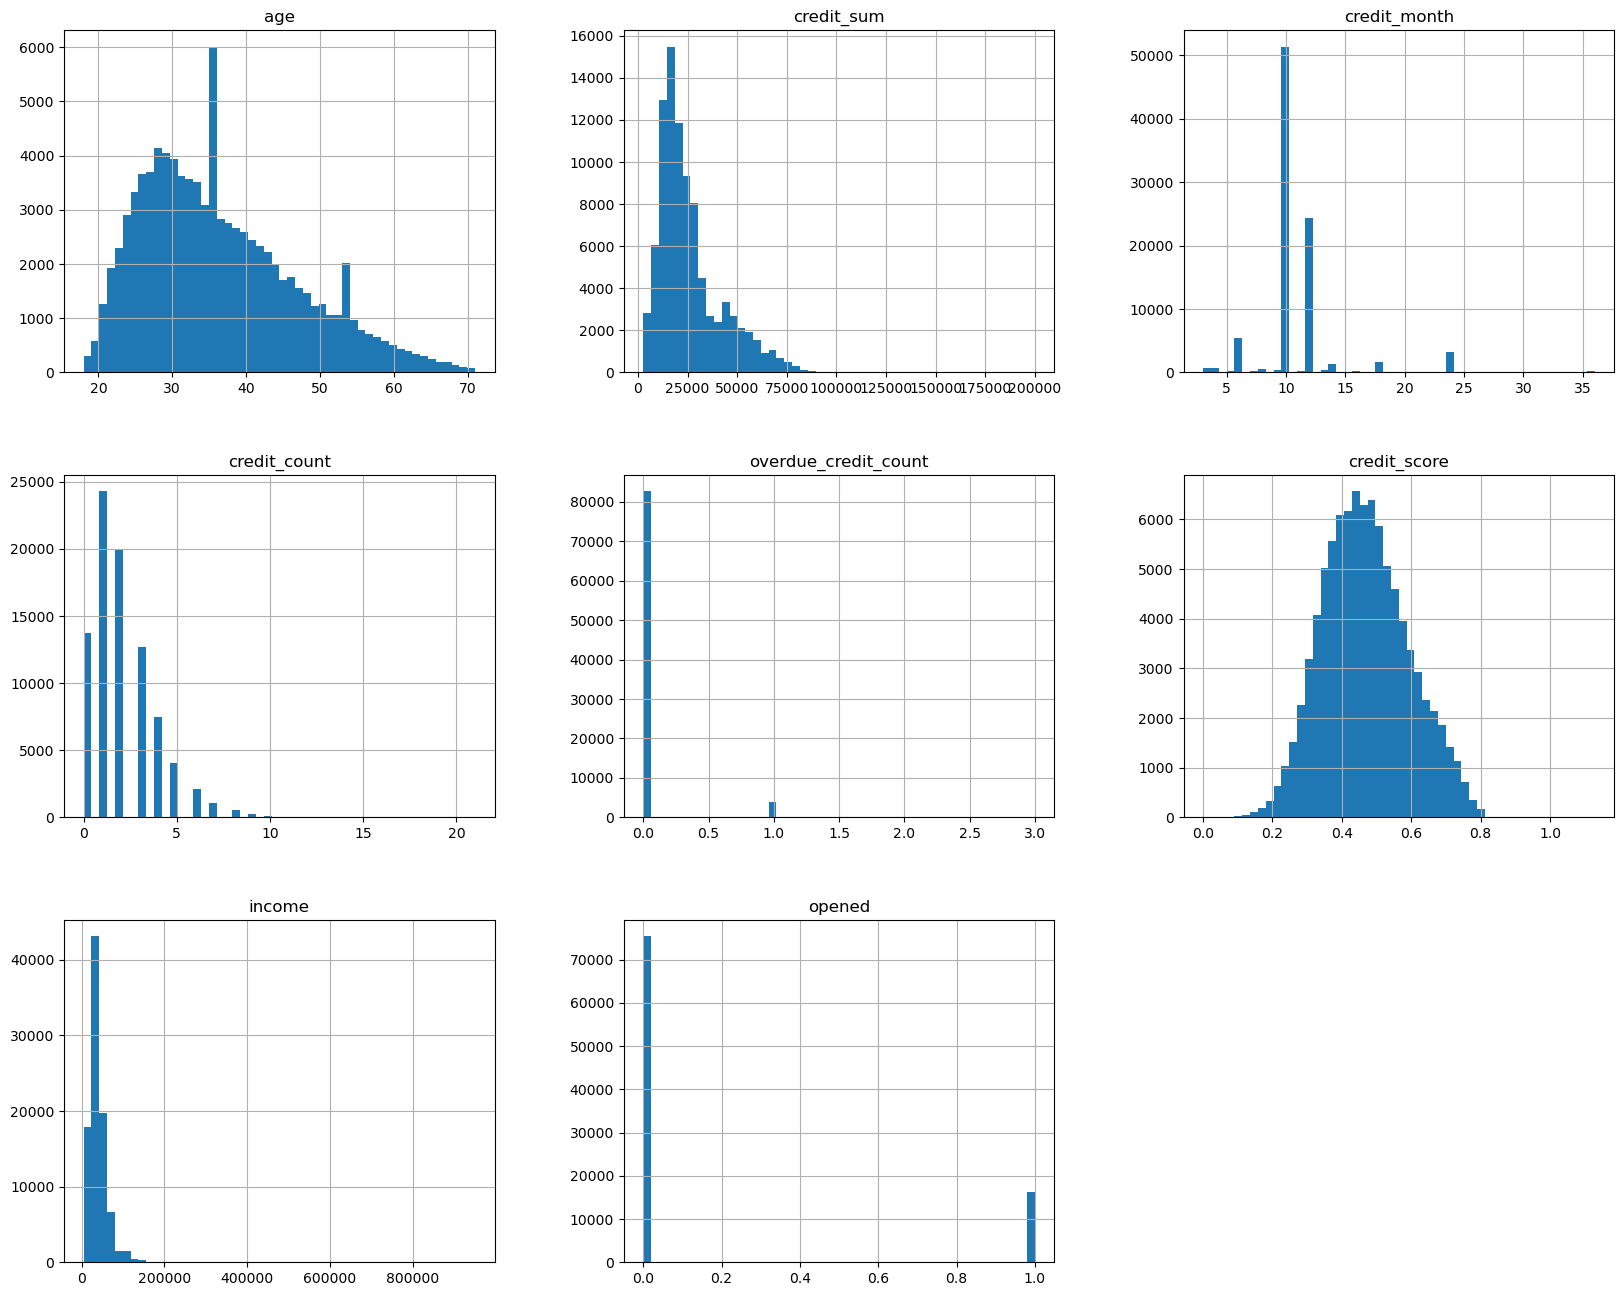

In [30]:
strat_train_set.hist(bins=50, figsize=(20, 16))